In [1]:
from tensorflow.python.keras import backend as k
import numpy as np
import pandas as pd

## keras.__version__


##   import keras
from tensorflow.python.keras import backend as k

#######################################################
#######################################################
from tensorflow.python.client import device_lib



def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    local_device_protos
    return [x.name for x in local_device_protos if x.device_type == "GPU"]


## dump GPU info
## from tensorflow.python.client import device_lib
## print(device_lib.list_local_devices())

import os
os.environ["CUDA_DEVICE_ORDER"] = "0000:02:00.0"  
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
##   !pip install --upgrade 'notebook>=6.0.1'

In [3]:
## train = pd.read_csv("1104train-v3.csv").sample(frac=1,axis=0)
train_data = pd.read_csv("0703train-v3.csv")
train_data =train_data.to_numpy()

train_targets=pd.read_csv("0703trainTar-v3.csv")
train_targets=train_targets.to_numpy()

valid_data=pd.read_csv("0703valid-v3.csv")
valid_data=valid_data.to_numpy()

valid_targets=pd.read_csv("0703validTar-v3.csv")
valid_targets=valid_targets.to_numpy()

test_data= pd.read_csv("0703test-v3.csv")
test_data=test_data.to_numpy()

leng = test_data.shape[1]

In [4]:
train_data.shape


(15184, 20)

In [5]:
test_data.shape

(6485, 20)

In [6]:
valid_data.shape

(2161, 20)

In [7]:
train_data

array([[3.000e+00, 1.750e+00, 1.670e+03, ..., 1.670e+03, 3.400e+01,
        3.400e+01],
       [4.000e+00, 2.500e+00, 1.921e+03, ..., 1.921e+03, 1.000e+01,
        1.000e+01],
       [4.000e+00, 2.500e+00, 3.710e+03, ..., 3.710e+03, 1.400e+01,
        1.400e+01],
       ...,
       [3.000e+00, 2.500e+00, 1.520e+03, ..., 1.520e+03, 3.000e+01,
        3.000e+01],
       [4.000e+00, 2.500e+00, 2.000e+03, ..., 2.000e+03, 3.000e+01,
        3.000e+01],
       [4.000e+00, 2.250e+00, 3.130e+03, ..., 3.130e+03, 3.300e+01,
        3.300e+01]])

In [8]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

valid_data -= mean
valid_data /= std

test_data -= mean
test_data /= std


# Predicting house prices: a regression example

This notebook contains the code samples found in Chapter 3, Section 6 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----


In our two previous examples, we were considering classification problems, where the goal was to predict a single discrete label of an 
input data point. Another common type of machine learning problem is "regression", which consists of predicting a continuous value instead 
of a discrete label. For instance, predicting the temperature tomorrow, given meteorological data, or predicting the time that a 
software project will take to complete, given its specifications.

Do not mix up "regression" with the algorithm "logistic regression": confusingly, "logistic regression" is not a regression algorithm, 
it is a classification algorithm.

## The Boston Housing Price dataset


We will be attempting to predict the median price of homes in a given Boston suburb in the mid-1970s, given a few data points about the 
suburb at the time, such as the crime rate, the local property tax rate, etc.

The dataset we will be using has another interesting difference from our two previous examples: it has very few data points, only 506 in 
total, split between 404 training samples and 102 test samples, and each "feature" in the input data (e.g. the crime rate is a feature) has 
a different scale. For instance some values are proportions, which take a values between 0 and 1, others take values between 1 and 12, 
others between 0 and 100...

Let's take a look at the data:

In [9]:
## from keras.datasets import boston_housing

##     (train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()


As you can see, we have 404 training samples and 102 test samples. The data comprises 13 features. The 13 features in the input data are as 
follow:

1. Per capita crime rate.
2. Proportion of residential land zoned for lots over 25,000 square feet.
3. Proportion of non-retail business acres per town.
4. Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
5. Nitric oxides concentration (parts per 10 million).
6. Average number of rooms per dwelling.
7. Proportion of owner-occupied units built prior to 1940.
8. Weighted distances to five Boston employment centres.
9. Index of accessibility to radial highways.
10. Full-value property-tax rate per $10,000.
11. Pupil-teacher ratio by town.
12. 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.
13. % lower status of the population.

The targets are the median values of owner-occupied homes, in thousands of dollars:


The prices are typically between \$10,000 and \$50,000. If that sounds cheap, remember this was the mid-1970s, and these prices are not 
inflation-adjusted.

## Preparing the data


It would be problematic to feed into a neural network values that all take wildly different ranges. The network might be able to 
automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice to deal 
with such data is to do feature-wise normalization: for each feature in the input data (a column in the input data matrix), we 
will subtract the mean of the feature and divide by the standard deviation, so that the feature will be centered around 0 and will have a 
unit standard deviation. This is easily done in Numpy:


Note that the quantities that we use for normalizing the test data have been computed using the training data. We should never use in our 
workflow any quantity computed on the test data, even for something as simple as data normalization.

## Building our network


Because so few samples are available, we will be using a very small network with two 
hidden layers, each with 64 units. In general, the less training data you have, the worse overfitting will be, and using 
a small network is one way to mitigate overfitting.

In [10]:
from tensorflow.keras import models
from tensorflow.keras import layers
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')
# 設定 Keras 使用的 Session

def build_model(input_shape1):
    model = models.Sequential()
    model.add(layers.Dense(32, kernel_initializer='normal',activation='relu',input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(128, kernel_initializer='normal',activation='relu'))
    model.add(layers.Dense(128, kernel_initializer='normal',activation='relu'))
    model.add(layers.Dense(128, kernel_initializer='normal',activation='relu'))
    model.add(layers.Dense(128, kernel_initializer='normal',activation='relu'))
    model.add(layers.Dense(128, kernel_initializer='normal',activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [11]:
# leng


Our network ends with a single unit, and no activation (i.e. it will be linear layer). 
This is a typical setup for scalar regression (i.e. regression where we are trying to predict a single continuous value). 
Applying an activation function would constrain the range that the output can take; for instance if 
we applied a `sigmoid` activation function to our last layer, the network could only learn to predict values between 0 and 1. Here, because 
the last layer is purely linear, the network is free to learn to predict values in any range.

Note that we are compiling the network with the `mse` loss function -- Mean Squared Error, the square of the difference between the 
predictions and the targets, a widely used loss function for regression problems.

We are also monitoring a new metric during training: `mae`. This stands for Mean Absolute Error. It is simply the absolute value of the 
difference between the predictions and the targets. For instance, a MAE of 0.5 on this problem would mean that our predictions are off by 
\$500 on average.

## Validating our approach using K-fold validation


To evaluate our network while we keep adjusting its parameters (such as the number of epochs used for training), we could simply split the 
data into a training set and a validation set, as we were doing in our previous examples. However, because we have so few data points, the 
validation set would end up being very small (e.g. about 100 examples). A consequence is that our validation scores may change a lot 
depending on _which_ data points we choose to use for validation and which we choose for training, i.e. the validation scores may have a 
high _variance_ with regard to the validation split. This would prevent us from reliably evaluating our model.

The best practice in such situations is to use K-fold cross-validation. It consists of splitting the available data into K partitions 
(typically K=4 or 5), then instantiating K identical models, and training each one on K-1 partitions while evaluating on the remaining 
partition. The validation score for the model used would then be the average of the K validation scores obtained.

train_targetsn terms of code, this is straightforward:

In [12]:
##############
#  phase 1
##############
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 140  #50
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)


    # Build the Keras model (already compiled)
    model = build_model(leng)
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=64, shuffle=True, verbose=2)
    
    
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
    

processing fold # 0
Train on 11388 samples
Epoch 1/140
11388/11388 - 1s - loss: 195751043384.1995 - mae: 320574.3438
Epoch 2/140
11388/11388 - 0s - loss: 36316527175.3959 - mae: 126409.4766
Epoch 3/140
11388/11388 - 0s - loss: 30492607749.4851 - mae: 110326.7734
Epoch 4/140
11388/11388 - 0s - loss: 29297476038.6315 - mae: 108034.3125
Epoch 5/140
11388/11388 - 0s - loss: 28454220271.6347 - mae: 106103.2812
Epoch 6/140
11388/11388 - 0s - loss: 27778611485.2237 - mae: 104592.1172
Epoch 7/140
11388/11388 - 0s - loss: 27726911338.3744 - mae: 103949.3438
Epoch 8/140
11388/11388 - 0s - loss: 27061151375.3312 - mae: 102779.0234
Epoch 9/140
11388/11388 - 0s - loss: 26821248592.3878 - mae: 102688.7109
Epoch 10/140
11388/11388 - 0s - loss: 27126937759.3368 - mae: 102591.9766
Epoch 11/140
11388/11388 - 0s - loss: 26661593660.9652 - mae: 101833.4844
Epoch 12/140
11388/11388 - 0s - loss: 26492446388.7376 - mae: 101442.2109
Epoch 13/140
11388/11388 - 0s - loss: 26573264050.7594 - mae: 101584.8828
Epo

In [13]:
# Get a fresh, compiled model.
model = build_model(leng)
# Train it on the entirety of the data.
model.fit(train_data, train_targets, epochs=200, batch_size=32, shuffle=True, verbose=2,
          validation_data=(valid_data, valid_targets))
test_mse_score, test_mae_score = model.evaluate(train_data, train_targets, verbose=0)

Train on 15184 samples, validate on 2161 samples
Epoch 1/200
15184/15184 - 1s - loss: 104266180877.7576 - mae: 203852.7031 - val_loss: 32894426019.5983 - val_mae: 116163.0469
Epoch 2/200
15184/15184 - 1s - loss: 35043628430.1623 - mae: 116064.3828 - val_loss: 30305658139.8390 - val_mae: 110126.6328
Epoch 3/200
15184/15184 - 1s - loss: 33883114419.3888 - mae: 113273.4688 - val_loss: 31636826520.4627 - val_mae: 112914.8750
Epoch 4/200
15184/15184 - 1s - loss: 32364208377.2561 - mae: 111165.3594 - val_loss: 28307210274.1175 - val_mae: 105591.4297
Epoch 5/200
15184/15184 - 1s - loss: 32496706601.0032 - mae: 110587.5859 - val_loss: 30573172697.1439 - val_mae: 112094.5781
Epoch 6/200
15184/15184 - 1s - loss: 32127784940.5774 - mae: 110696.8828 - val_loss: 27588076285.7492 - val_mae: 103743.3359
Epoch 7/200
15184/15184 - 1s - loss: 32038781082.3014 - mae: 109949.1406 - val_loss: 26883003346.0361 - val_mae: 104067.0703
Epoch 8/200
15184/15184 - 1s - loss: 31422463954.6807 - mae: 108285.2344 - 

In [14]:
## predict = model.predict(test_data)
predict = model.predict(test_data)
import numpy
numpy.savetxt("fooPh1.csv", predict, header='id,price', delimiter=",")


    ## print(type(partial_train_targets))
    ## print(type(partial_train_data))
    ## print(type(val_targets))
    ## print(type(val_data))
    
#  phase 1

In [15]:
all_scores

[82708.03, 71577.086, 87498.6, 73858.41]


As you can notice, the different runs do indeed show rather different validation scores, from 2.1 to 2.9. Their average (2.4) is a much more 
reliable metric than any single of these scores -- that's the entire point of K-fold cross-validation. In this case, we are off by \$2,400 on 
average, which is still significant considering that the prices range from \$10,000 to \$50,000. 

Let's try training the network for a bit longer: 500 epochs. To keep a record of how well the model did at each epoch, we will modify our training loop 
to save the per-epoch validation score log:

In [16]:
from tensorflow.keras import backend as K

# Some memory clean-up
K.clear_session()

In [17]:
##############
#  phase 2
##############
num_epochs = 50  # 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    
    # Build the Keras model (already compiled)
    model = build_model(leng)
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=32, verbose=2,shuffle=True,)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
    print(len(all_mae_histories))

    average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
    ]
#  phase 2    

processing fold # 0
Train on 11388 samples, validate on 3796 samples
Epoch 1/50
11388/11388 - 1s - loss: 127444396291.6867 - mae: 236345.9531 - val_loss: 52844680924.1222 - val_mae: 138069.4844
Epoch 2/50
11388/11388 - 1s - loss: 32000855975.5195 - mae: 114531.8359 - val_loss: 48574945922.0232 - val_mae: 128767.5938
Epoch 3/50
11388/11388 - 1s - loss: 29669881838.0162 - mae: 108511.8125 - val_loss: 49363463151.8145 - val_mae: 127164.6875
Epoch 4/50
11388/11388 - 1s - loss: 28561646515.3888 - mae: 106219.3672 - val_loss: 53627962823.8904 - val_mae: 129307.4219
Epoch 5/50
11388/11388 - 1s - loss: 28091308131.9902 - mae: 104683.7031 - val_loss: 47551463003.1781 - val_mae: 132022.3906
Epoch 6/50
11388/11388 - 1s - loss: 28277652539.1668 - mae: 105592.1797 - val_loss: 52843881574.5079 - val_mae: 129334.5547
Epoch 7/50
11388/11388 - 1s - loss: 27235885616.5564 - mae: 103311.9375 - val_loss: 52621055086.0611 - val_mae: 130236.8672
Epoch 8/50
11388/11388 - 1s - loss: 27603779311.3649 - mae: 10

In [18]:
print(type(history.history['val_mae']))


<class 'list'>


We can then compute the average of the per-epoch MAE scores for all folds:

In [19]:
print(len(average_mae_history))

50


Let's plot this:

In [20]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

<Figure size 640x480 with 1 Axes>


It may be a bit hard to see the plot due to scaling issues and relatively high variance. Let's:

* Omit the first 10 data points, which are on a different scale from the rest of the curve.
* Replace each point with an exponential moving average of the previous points, to obtain a smooth curve.

In [21]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [22]:
# average_mae_history[10:]

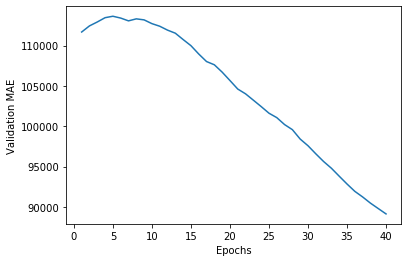

In [23]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()


According to this plot, it seems that validation MAE stops improving significantly after 80 epochs. Past that point, we start overfitting.

Once we are done tuning other parameters of our model (besides the number of epochs, we could also adjust the size of the hidden layers), we 
can train a final "production" model on all of the training data, with the best parameters, then look at its performance on the test data:

In [24]:
# Get a fresh, compiled model.
model = build_model(leng)
# Train it on the entirety of the data.
model.fit(train_data, train_targets, epochs=50, batch_size=32, verbose=2,
          validation_data=(valid_data, valid_targets))
test_mse_score, test_mae_score = model.evaluate(train_data, train_targets, verbose=0)

Train on 15184 samples, validate on 2161 samples
Epoch 1/50
15184/15184 - 1s - loss: 107171230319.6797 - mae: 206957.5781 - val_loss: 33383836966.2638 - val_mae: 115424.0469
Epoch 2/50
15184/15184 - 1s - loss: 35671345357.0158 - mae: 116172.7812 - val_loss: 30006162986.8839 - val_mae: 110220.0234
Epoch 3/50
15184/15184 - 1s - loss: 33825627259.0095 - mae: 112797.8359 - val_loss: 30665308498.3323 - val_mae: 109214.6484
Epoch 4/50
15184/15184 - 1s - loss: 33093447487.9326 - mae: 111341.9453 - val_loss: 28697054602.7210 - val_mae: 105526.5547
Epoch 5/50
15184/15184 - 1s - loss: 32478779670.3899 - mae: 110299.7109 - val_loss: 28977497161.4475 - val_mae: 105747.5859
Epoch 6/50
15184/15184 - 1s - loss: 32202709930.7566 - mae: 109252.9141 - val_loss: 27635501015.2485 - val_mae: 103115.8281
Epoch 7/50
15184/15184 - 1s - loss: 31787935281.0959 - mae: 108944.5469 - val_loss: 27665659015.9963 - val_mae: 105817.2344
Epoch 8/50
15184/15184 - 1s - loss: 30931562707.4900 - mae: 106949.7422 - val_loss

In [25]:
## predict = model.predict(test_data)
predict = model.predict(test_data)
import numpy
numpy.savetxt("foo.csv", predict, delimiter=",")

We are still off by about \$2,550.

## Wrapping up


Here's what you should take away from this example:

* Regression is done using different loss functions from classification; Mean Squared Error (MSE) is a commonly used loss function for 
regression.
* Similarly, evaluation metrics to be used for regression differ from those used for classification; naturally the concept of "accuracy" 
does not apply for regression. A common regression metric is Mean Absolute Error (MAE).
* When features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing step.
* When there is little data available, using K-Fold validation is a great way to reliably evaluate a model.
* When little training data is available, it is preferable to use a small network with very few hidden layers (typically only one or two), 
in order to avoid severe overfitting.

This example concludes our series of three introductory practical examples. You are now able to handle common types of problems with vector data input:

* Binary (2-class) classification.
* Multi-class, single-label classification.
* Scalar regression.

In the next chapter, you will acquire a more formal understanding of some of the concepts you have encountered in these first examples, 
such as data preprocessing, model evaluation, and overfitting.